# Some MD-related algorithms

Here I will present codes that implement some of the algorithms discussed in class.

We start by simulating the motion of two particles of mass $m$ connected by a spring of constant $k$ with the Velocity Verlet method and different thermostats.

We start by importing some modules and defining a utility function

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# utility function to plot some quantities
def make_plots(dist_out, v1_out, U_out, Uk_out, Utot_out):
    # plot position and velocity
    plt.figure(figsize=(5, 5))
    plt.plot(dist_out, v1_out, 'o')
    plt.xlabel('Distance')
    plt.ylabel('Velocity')
    plt.title('Phase space')
    plt.show()
    
    # plot the potential, kinetic and total energy as a function of time
    ts = np.linspace(0, num_steps, len(Utot_out)) * dt
    plt.plot(ts, U_out, label="Potential energy")
    plt.plot(ts, Uk_out, label="Kinetic energy")
    plt.plot(ts, Utot_out, label="Total energy")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Total energy')
    plt.title('Energy')
    plt.show()

## No thermostat

We start by simulating a system that is not coupled to a thermostat. The total energy of the system, which should be conserved throughout the simulation, is given by

$$
U_\text{tot} = \frac{1}{2} m (v_1^2 + v_2^2) + \frac{1}{2} k (|x_1 - x_2| - x_0)^2,
$$

The force acting on particle $i$ is given by

$$
F_i = -\frac{dU_\text{tot}}{dx_i} = -k (|x_1 - x_2| - x_0) \frac{x_1 - x_2}{|x_1 - x_2|},
$$

where the latter factor is due to the derivative of $|x_1 - x_2|$. Note that in numerical implementations the denominator can get very close to zero, leading to numerical instabilities. This happens because particles can get very close to each other, since there is no excluded volume. To avoid this issue, in the code below I use $\text{sign}(x_1 - x_2)$ in its place. Try putting the original expression: you'll see a very bad energy conservation, together with a trajectory that is clearly wrong.

In the next cell I define the model constants and the functions used to compute the force acting between the two particles, as well as the potential and kinetic energy of the system.

In [15]:
k = 1.0           # force constant
m = 1.0           # mass
dt = 0.01         # timestep
x0 = 1.2          # equilibrium position

# return the force acting on p1
def force(p1, p2, k, x0):
    distance = np.fabs(p1 - p2)
    unit_vector = np.sign(p1 - p2)
    # unit_vector = (p1 - p2) / distance # try uncommenting this line and see what happens!
    return -k * (distance - x0) * unit_vector

def energy(p1, p2, k, x0):
    distance = np.fabs(p1 - p2)
    return 0.5 * k * (distance - x0)**2

def kinetic_energy(velocities, m):
    return 0.5 * m * np.sum(velocities**2)

Now we define some helper functions used to set the initial conditions, update and print the observables

In [16]:
def initial_conditions():
    positions = np.array([0.0, 1.0])
    velocities = np.array([0.0, 0.0])
    forces = np.array([force(positions[0], positions[1], k, x0), force(positions[1], positions[0], k, x0)])
    return positions, velocities, forces

def print_energies(positions, velocities, k, x0, m):
    U = energy(positions[0], positions[1], k, x0)
    Uk = kinetic_energy(velocities, m)
    Utot = U + Uk
    print(f"{i * dt:10.2f} {U:10.4f} {Uk:10.4f} {Utot:10.4f}")

def update_observables(dist_out, v1_out, U_out, Uk_out, Utot_out):
    dist_out.append(positions[0] - positions[1])
    v1_out.append(velocities[0])

    U = energy(positions[0], positions[1], k, x0)
    Uk = kinetic_energy(velocities, m)
    
    U_out.append(U)
    Uk_out.append(Uk)
    Utot_out.append(U + Uk)

Now I define a function that is used to integrate forward in time the equations of motion. Here we make use of the Velocity Verlet method presented in class:

1. Update the velocity, first step, $v(t + \Delta t / 2) = v(t) + \frac{1}{2} a(t) \Delta t$.
2. Update the position, $x(t + \Delta t) = x(t) + v(t + \Delta t / 2)\Delta t$.
3. Calculate the force (and therefore the acceleration) using the new position.
4. Update the velocity, second step, $v(t + \Delta t) = v(t + \Delta t / 2) + \frac{1}{2} a(t + \Delta t)\Delta t$.

In [17]:
def integrate(positions, velocities, forces, m, dt):
    # first step
    velocities += 0.5 * dt * forces / m
    positions += velocities * dt

    #  update the forces
    forces[0] = force(positions[0], positions[1], k, x0)
    forces[1] = force(positions[1], positions[0], k, x0)
    # forces[1] = -forces[0] # we could also use Netwon's third law

    # second step
    velocities += 0.5 * dt * forces / m

Here is the part of the code that uses the above functions. We first generate the initial conditions and initialise the data structures where the observables will be stored.

Then, we integrate the equations of motion for `num_steps`, keeping track of the observables.

In [18]:
# set some simulation options
num_steps = 1000  # number of time steps
save_freq = 10    # save position, velocity and energy every this number of steps
print_freq = 100  # output time and energy every this number of steps

# set the initial conditions
positions, velocities, forces = initial_conditions()

# initialse the observables
dist_out = [] # distance between the particles
v1_out = []   # velocity of the first particle
U_out = []    # potential energy
Uk_out = []   # kinetic energy
Utot_out = [] # total energy

print(f"{'t':>10} {'U':>10} {'Uk':>10} {'Utot':>10}") # print the first line
# run the actual simulation
for i in range(num_steps):
    # save the observables
    if i % save_freq == 0:
        update_observables(dist_out, v1_out, U_out, Uk_out, Utot_out)

    # print to screen the energies
    if i % print_freq == 0:
        print_energies(positions, velocities, k, x0, m)

    # integrate forward all degrees of freedom
    integrate(positions, velocities, forces, m, dt)

         t          U         Uk       Utot
      0.00     0.0200     0.0000     0.0200
      1.00     0.0005     0.0195     0.0200
      2.00     0.0181     0.0019     0.0200
      3.00     0.0041     0.0159     0.0200
      4.00     0.0131     0.0069     0.0200
      5.00     0.0099     0.0101     0.0200
      6.00     0.0070     0.0130     0.0200
      7.00     0.0158     0.0042     0.0200
      8.00     0.0020     0.0180     0.0200
      9.00     0.0195     0.0005     0.0200


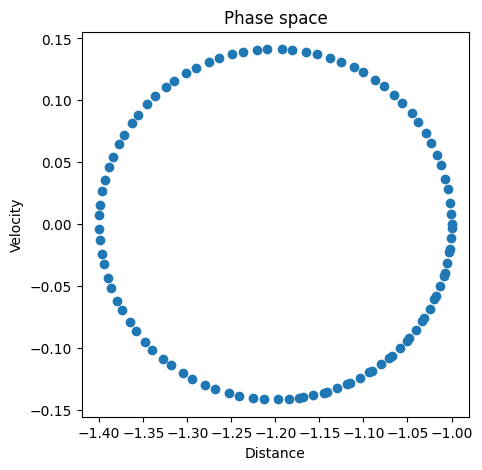

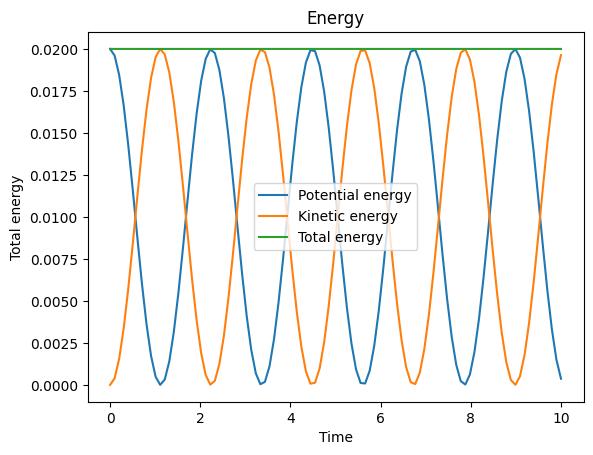

In [19]:
make_plots(dist_out, v1_out, U_out, Uk_out, Utot_out)

## The Andersen thermostat

Now we couple the system to a heat bath by using the simplest thermostat we studied in class. We first define a "collision frequency" $\nu$, and then use it to calculate the probability $\nu \Delta t$ that, at each time step, a random particle undergoes a collision. In this simple scheme, if a particle undergoes a collision, its velocity is extracted from the Maxwell-Boltzmann distribution corresponding to the simulated temperature $T$.

The code below is very similar to the one above, with the only difference being the definitions of the constants, and the collision step.

In [20]:
# set some simulation options
num_steps = 1000000  # number of time steps
save_freq = 100    # save position, velocity and energy every this number of steps
print_freq = 100000  # output time and energy every this number of steps

# thermostat constants
T = 1.0
rescaling_factor = T**0.5
nu = 1e-1
p = nu * dt

# set the initial conditions
positions, velocities, forces = initial_conditions()

# initialse the observables
dist_out = [] # distance between the particles
v1_out = []   # velocity of the first particle
U_out = []    # potential energy
Uk_out = []   # kinetic energy
Utot_out = [] # total energy

print(f"{'t':>10} {'U':>10} {'Uk':>10} {'Utot':>10}") # print the first line
# run the actual simulation
for i in range(num_steps):
    # save the observables
    if i % save_freq == 0:
        update_observables(dist_out, v1_out, U_out, Uk_out, Utot_out)

    # print to screen the energies
    if i % print_freq == 0:
        print_energies(positions, velocities, k, x0, m)

    # integrate forward all degrees of freedom
    integrate(positions, velocities, forces, m, dt)
    for i in range(2):
        if np.random.random() < p:
            velocities[i] = np.random.normal() * rescaling_factor

         t          U         Uk       Utot
      0.00     0.0200     0.0000     0.0200
   1000.00     0.1798     0.6580     0.8378
   2000.00     0.4541     0.0227     0.4768
   3000.00     0.0499     0.3095     0.3594
   4000.00     0.7083     1.7803     2.4885
   5000.00     0.3073     2.3755     2.6827
   6000.00     0.0859     2.6666     2.7525
   7000.00     0.0126     0.6526     0.6652
   8000.00     0.1371     1.8857     2.0229
   9000.00     0.0379     2.4708     2.5087


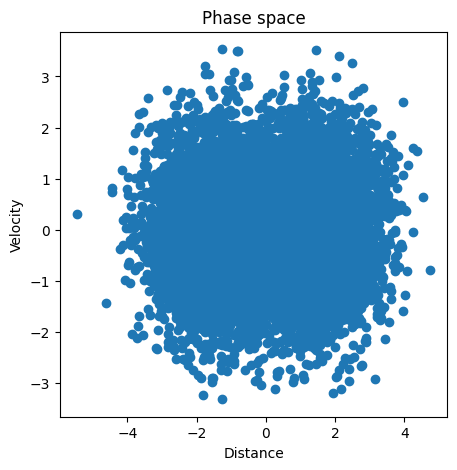

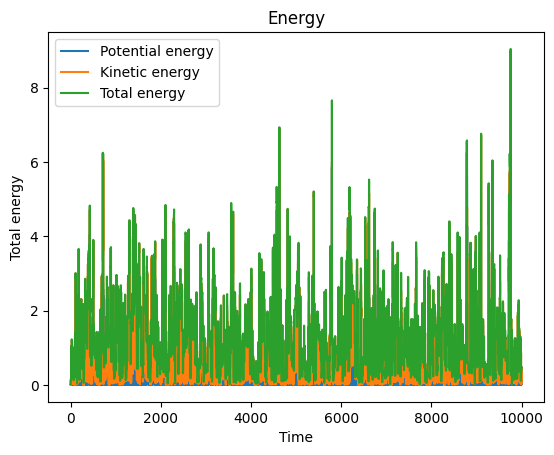

In [21]:
make_plots(dist_out, v1_out, U_out, Uk_out, Utot_out)

## The energy of a Lennard-Jones sytem

Here I will present a code that initialises a system composed of spheres interacting through a Lennard-Jones potential, and then computes its energy by using periodic boundary conditions.

First we set the the number of particles and the overall density, from which we get the dimensions of the simulation cubic box. Then we use these values to initialse the particle positions on a cubic lattice to avoid particle overlaps.

In [22]:
N = 20
rho = 0.1
V = N / rho
box_length = V**(1./3.)
box = np.array([box_length, box_length, box_length])

def generate_lattice_positions(N, box_length):   
    # find the smallest integer grid size that can contain N particles
    grid_size = int(np.ceil(N ** (1/3)))
    cell_length = box_length / grid_size  # Lattice spacing

    positions = []
    # loop through each position on the cubic grid until we reach N particles
    for x in range(grid_size):
        for y in range(grid_size):
            for z in range(grid_size):
                if len(positions) < N:
                    positions.append([x * cell_length, y * cell_length, z * cell_length])
                else:
                    break

    return np.array(positions)
    
positions = generate_lattice_positions(N, box_length)

We then define the Lennard-Jones constants and a function that returns the pair potential. Here we use a truncated and shifted interaction with $r_c = 2.5 \sigma$. Note the second line of the `LJ_energy()` function, where periodic boundary conditions are applied.

In [23]:
def LJ_function(r, epsilon, sigma):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

sigma = 1.0
epsilon = 1.0
rcut = 2.5 * sigma
E_cut = LJ_function(rcut, epsilon, sigma)

def LJ_energy(p1, p2, epsilon, sigma):    
    distance = p2 - p1
    distance -= np.round(distance / box) * box # periodic boundary conditions
    r = np.sqrt(np.dot(distance, distance))
    if r < rcut:
        return LJ_function(r, epsilon, sigma) - E_cut
    else:
        return 0

We now loop over all pairs to compute the potential energy per particle:

In [24]:
E = 0.0
for i in range(N):
    for j in range(i + 1, N):
        E += LJ_energy(positions[i], positions[j], epsilon, sigma)
E /= N

print("Total potential energy per particle:", E)

Total potential energy per particle: -0.1381362659100002
